# Sentiment Analysis on Financial Tweets

In [1]:
import yfinance as yf
import pandas as pd

## Importing twitter dataset

In [2]:
#twitter data
splits = {'train': 'sent_train.csv', 'validation': 'sent_valid.csv'}
tweets = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["train"])
tweets

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


## Preprocessing twitter data

In [3]:
import spacy
import re
from spacy.util import minibatch

nlp = spacy.load('en_core_web_sm')

def remove_stuff(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    
    symbol_pattern = re.compile(r'[^A-Za-z0-9\s]')
    text = symbol_pattern.sub(r'', text)
    
    return text

def preprocess_text(text):

    text = remove_stuff(text)
    docs = nlp(text)
    
    processed_tokens = [
        token.lemma_.lower() for token in docs 
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    
    return " ".join(processed_tokens)

tweets['processed_text'] = tweets['text'].apply(preprocess_text)

tweets

,text,label,processed_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reel expectation meat
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura point booking weakness carnival...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cut neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slide piper jaffray pt cut
...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,weeks gainers losers stoxx europe 50 dec 26 ec...
9539,Tupperware Brands among consumer gainers; Unil...,2,tupperware brands consumer gainer unilever lea...
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,vtv therapeutic lead healthcare gainer myomo b...
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,work xpo pyx amkr hour mover


## Feeding into Mood analyzer : Vader and Hugging Face(BERT)

In [4]:
#vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return analyzer.polarity_scores(text)

tweets['Vader_Scores'] = tweets['processed_text'].apply(analyze_sentiment)
tweets['vader_compound'] = tweets['Vader_Scores'].apply(lambda x: x['compound'])
tweets.drop(columns=['Vader_Scores'], inplace=True)
tweets

,text,label,processed_text,vader_compound
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reel expectation meat,0.0000
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura point booking weakness carnival...,-0.4215
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...,-0.1531
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cut neutral,-0.2732
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slide piper jaffray pt cut,-0.2732
...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,weeks gainers losers stoxx europe 50 dec 26 ec...,-0.5267
9539,Tupperware Brands among consumer gainers; Unil...,2,tupperware brands consumer gainer unilever lea...,-0.5267
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,vtv therapeutic lead healthcare gainer myomo b...,-0.5267
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,work xpo pyx amkr hour mover,0.0000


In [10]:
#Hugging Face(BERT)
from transformers import pipeline
import torch
from tqdm.notebook import tqdm
import pandas as pd

device = 0 if torch.cuda.is_available() else -1

sentiment_pipeline = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment', device=device)

def analyze_sentiment_custom_labels(text, custom_labels=None):
    result = sentiment_pipeline(text)
    label = result[0]['label']
    score = result[0]['score']
    
    model_to_custom = {
        'LABEL_2': custom_labels.get('POSITIVE', 'POSITIVE'),  # Positive
        'LABEL_1': custom_labels.get('NEUTRAL', 'NEUTRAL'),   # Neutral
        'LABEL_0': custom_labels.get('NEGATIVE', 'NEGATIVE')   # Negative
    }

    if label in model_to_custom:
        label = model_to_custom[label]
    else:
        print(f"Unexpected label encountered: {label}")
        label = '2'  # Default to '2' for unexpected labels

    return {'custom_label': label, 'score': score}

# Custom label mapping
custom_labels = {
    'POSITIVE': 1,
    'NEGATIVE': 0,
    'NEUTRAL': 2,
}

def analyze_and_store_sentiment(text):
    sentiment = analyze_sentiment_custom_labels(text, custom_labels)
    return sentiment['custom_label']

# Assuming 'tweets' is your DataFrame and 'processed_text' is the column with text
tweets['BERT_sentiment_label'] = [analyze_and_store_sentiment(text) for text in tqdm(tweets['processed_text'], desc="Analyzing Sentiment Labels")]
tweets

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Analyzing Sentiment Labels:   0%|          | 0/9543 [00:00<?, ?it/s]

,text,label,processed_text,vader_compound,BERT_sentiment_label
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reel expectation meat,0.0000,2
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura point booking weakness carnival...,-0.4215,2
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...,-0.1531,2
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cut neutral,-0.2732,2
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slide piper jaffray pt cut,-0.2732,2
...,...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,weeks gainers losers stoxx europe 50 dec 26 ec...,-0.5267,2
9539,Tupperware Brands among consumer gainers; Unil...,2,tupperware brands consumer gainer unilever lea...,-0.5267,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,vtv therapeutic lead healthcare gainer myomo b...,-0.5267,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,work xpo pyx amkr hour mover,0.0000,2


In [12]:
unique_count = tweets['BERT_sentiment_label'].nunique()

print(f"The 'text' column has {unique_count} unique values.")

The 'text' column has 3 unique values.


## Accuracy of preexisting models

In [15]:
def vader_to_label(compound_score):
    if compound_score >= 0.5:
        return 1  # Positive
    elif compound_score <= -0.5:
        return 0  # Negative
    else:
        return 2  # Neutral

tweets['vader_label'] = tweets['vader_compound'].apply(vader_to_label)

vader_accuracy = (tweets['vader_label'] == tweets['label']).mean()
print(f"VADER Accuracy: {vader_accuracy:.2f}")

hf_accuracy = (tweets['BERT_sentiment_label'] == tweets['label']).mean()
print(f"Hugging Face Model Accuracy: {hf_accuracy:.2f}")

VADER Accuracy: 0.60
Hugging Face Model Accuracy: 0.64


## Training a custom model (SVM)

In [220]:
class_2 = tweets[tweets['label'] == 2].sample(1800, random_state=42)
class_1 = tweets[tweets['label'] == 1]
class_0 = tweets[tweets['label'] == 0]

balanced_tweets = pd.concat([class_0, class_1, class_2])
class_frequencies = balanced_tweets['label'].value_counts()
print(class_frequencies)

label
1    1923
2    1800
0    1442
Name: count, dtype: int64


In [221]:
test = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["validation"])
class_2 = test[test['label'] == 2].sample(450, random_state=42)
class_1 = test[test['label'] == 1]
class_0 = test[test['label'] == 0]

balanced_test = pd.concat([class_0, class_1, class_2])
class_frequencies = balanced_test['label'].value_counts()
print(class_frequencies)
balanced_test
X_train = balanced_tweets['text']
y_train = balanced_tweets['label']
X_val = balanced_test['text']
y_val = balanced_test['label']

label
1    475
2    450
0    347
Name: count, dtype: int64


In [306]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 3), stop_words='english', lowercase=True)

# Transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf',C=3, class_weight='balanced') # Try smaller values of C
svm_model.fit(X_train_tfidf, y_train)

# Predict on validation data
y_val_pred = svm_model.predict(X_val_tfidf)

# Calculate validation accuracy and classification report
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {accuracy:.2f}')
print('Validation Classification Report:')
print(report)

# Predict on training data
y_train_pred = svm_model.predict(X_train_tfidf)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.2f}')

scores_cross = cross_val_score(svm_model, X_train_tfidf, y_train, cv=5)
print(f"Cross-validation scores: {scores_cross}")

Validation Accuracy: 0.68
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       347
           1       0.69      0.68      0.69       475
           2       0.71      0.73      0.72       450

    accuracy                           0.68      1272
   macro avg       0.67      0.67      0.67      1272
weighted avg       0.68      0.68      0.68      1272

Training Accuracy: 0.94
Cross-validation scores: [0.50048403 0.47337851 0.48499516 0.48015489 0.53630203]


## testing an ensemble method with grid search

In [295]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for both SVM and BaggingClassifier
param_grid = {
    'base_estimator__C': [0.1, 1, 3, 10],  # Hyperparameters for SVM
    'base_estimator__kernel': ['linear', 'rbf'],  # Kernel types for SVM
    'n_estimators': [10, 20, 30],  # Number of SVM models in the ensemble
    'base_estimator__class_weight': ['balanced', None]  # Class weight options
}

# Initialize the base SVM model
svm_model = SVC()

# Initialize the BaggingClassifier with SVM as the base model
bagging_model = BaggingClassifier(base_estimator=svm_model, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print("Best parameters found:")
print(grid_search.best_params_)
print("Best cross-validation score:")
print(grid_search.best_score_)

# Best estimator
best_bagging_model = grid_search.best_estimator_

# Evaluate on validation data
y_val_pred = best_bagging_model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {accuracy:.2f}')
print('Validation Classification Report:')
print(report)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters found:
{'base_estimator__C': 3, 'base_estimator__class_weight': None, 'base_estimator__kernel': 'linear', 'n_estimators': 30}
Best cross-validation score:
0.4985479186834462
Validation Accuracy: 0.65
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       347
           1       0.68      0.67      0.67       475
           2       0.68      0.69      0.68       450

    accuracy                           0.65      1272
   macro avg       0.64      0.64      0.64      1272
weighted avg       0.65      0.65      0.65      1272



## Predictions and other evaluations

In [330]:
new_texts = ["$AAPL announces dividend", "msft has been so bad", "@elon announces 50% boost"]

# Transform new texts and predict
new_texts_tfidf = tfidf_vectorizer.transform(new_texts)
predictions = svm_model.predict(new_texts_tfidf)

print(predictions)

[2 0 1]


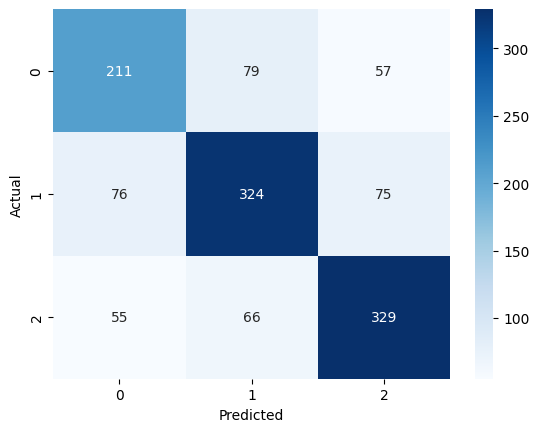

In [316]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

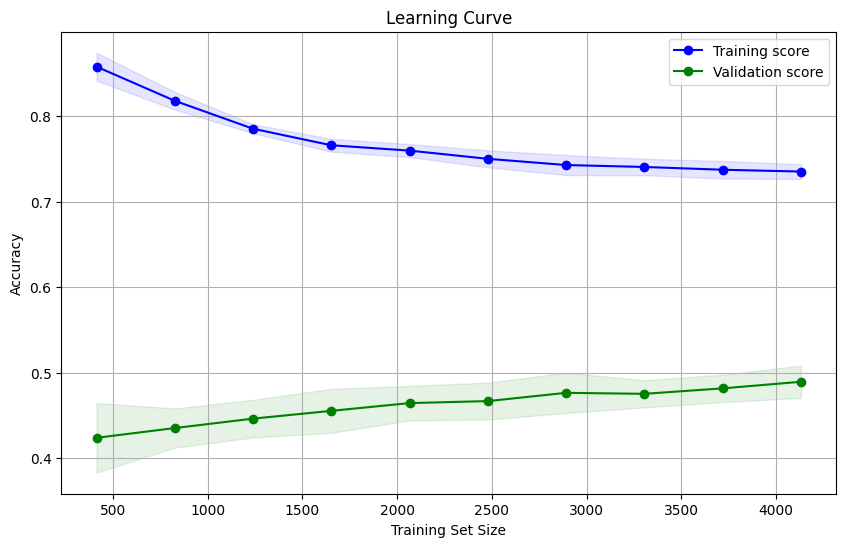

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='linear', class_weight='balanced'),        # Your model
    X_train_tfidf,                    # Features
    y_train,                          # Target labels                          # 5-fold cross-validation
    scoring='accuracy',               # Scoring method (use 'accuracy' for classification)
    n_jobs=-1,                        # Use all available cores
    train_sizes=np.linspace(0.1, 1.0, 10),  # Generate learning curve with 10 steps
    shuffle=True,                     # Shuffle data before splitting
    random_state=42                   # Ensure reproducibility
)

# Calculate mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation score")

# Fill the area between the mean and std deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

# Labels and title
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()